# ТЧМ. Лабораторна робота 1. Частина 2

Виконав студент 
ІІ курсу магістратури,
групи ОМ-2, 
Пишко Андрій

In [1]:
# Ресурси
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd

import time

### Клас для моделювання перешкоди

In [2]:
# Клас, в якому визначаються та зберігаються характеристики перешкоди
class Obstacle:
    def __init__(self, x, m):
        super().__init__()
        self.m = m  # Кількість точок дискретизації
        self.x = x  # Опорні точки перешкоди
        self.discretization_points = self.get_discretization_points()  # Точки дискретизації
        self.collocation_points = self.get_collocation_points()  # Точки колокації
        self.collocation_normals = self.get_collocation_normals()  # Нормалі
        self.x_index = self.get_x_index()

    def __str__(self):
        return (f'm={self.m}\n' + 'Точки дискретизації:\n' +
                pd.DataFrame(self.discretization_points, columns=['x_0j', 'y_0j']).to_string()
                + '\nТочки колокації:\n' + pd.DataFrame(self.collocation_points, columns=['x_k', 'y_k']).to_string() +
                '\nНормалі в точках колокації\n' +
                pd.DataFrame(self.collocation_normals, columns=['n_xk', 'n_yk']).to_string())

    # Отримати довжину контуру по його точкам
    @property
    def len(self):
        return np.sum([np.linalg.norm(end - start) for start, end in zip(self.x[:-1], self.x[1:])])

    # Отримати точки дискретизації
    def get_discretization_points(self):
        discretization_points = list()
        # Визначити координати та довжини сегментів контура
        segments_coordinates = [(start, end) for start, end in zip(self.x[:-1], self.x[1:])]
        segments_len = np.array([np.linalg.norm(end - start) for start, end in segments_coordinates])
        wild_points_number = self.m - len(self.x)  # Точки дискр., які залишилося розподілити
        dpu = wild_points_number / self.len  # Знаходимо частоту точок дискретизації
        segments_points = (segments_len * dpu).astype(int)  # Рівномірно розподіляємо точки дискр. по сегментам
        # Залишкові точки 
        extra_point_number = wild_points_number - segments_points.sum()  # Загальна кількість залишкових точок
        residual_points = segments_len * dpu - segments_points  # Доля точок, які залишилися зайвими по кожному сегменту
        # Поки не закінчаться зайві точки додаємо їх у той сегмент, в якому їхня доля найбільша
        while extra_point_number > 0:
            segment_idx = residual_points.argmax()
            segments_points[segment_idx] += 1
            residual_points[segment_idx] = 0
            extra_point_number -= 1
        # Знаходимо координати точок дискр.
        for idx in np.arange(len(self.x) - 1):
            step = (self.x[idx + 1] - self.x[idx]) / (segments_points[idx] + 1)
            discretization_points.extend([self.x[idx] + step * i for i in np.arange(segments_points[idx] + 1)])
        discretization_points.append(self.x[-1])
        return np.array(discretization_points)

    # Отримати точки колокацій
    def get_collocation_points(self):
        p_0k = self.discretization_points[:-1]
        p_0kp1 = self.discretization_points[1:]
        p_k = (p_0k + p_0kp1) / 2
        return p_k

    # Отримати нормалі в точках колокацій
    def get_collocation_normals(self):
        p_0k = self.discretization_points[:-1]
        p_0kp1 = self.discretization_points[1:]
        x_0k, y_0k = p_0k[:, 0], p_0k[:, 1]
        x_0kp1, y_0kp1 = p_0kp1[:, 0], p_0kp1[:, 1]
        n_k = (np.array((-(y_0kp1 - y_0k), x_0kp1 - x_0k)) / np.linalg.norm(p_0kp1 - p_0k, axis=1)).T
        return n_k

    # Отримати опорні точки
    def get_x_index(self):
        x_index = [np.where((self.discretization_points == x).all(axis=1))[0][0] for x in self.x]
        return x_index

    # Вивести контур перешкоди
    def plot(self):
        x, y = zip(*self.x)
        plt.plot(x, y)
        # x, y = zip(*self.discretization_points)
        # plt.scatter(x, y, edgecolors='black', label='Точки дискретизації')
        # x, y = zip(*self.collocation_points)
        # plt.scatter(x, y, marker='x', label='Точки колокацій')
        # Отримати рисунок векторів нормалей
        # n_k = self.collocation_normals
        # p_k = self.collocation_points
        # plt.quiver(p_k[:, 0], p_k[:, 1], n_k[:, 0], n_k[:, 1])
        plt.xlabel('x')
        plt.ylabel('y')
        plt.grid(True)

### Клас для моделювання нестаціонарного потоку

In [3]:
# Клас, який моделює процес обтікання стацiонарною течiєю фiксованої перешкоди
class UnsteadyFlowModel:
    def __init__(self, alpha, deterministicContour, p=None, g_0=0, delta=None):
        self.deterministicContour = deterministicContour  # Непроникний контур L_d.
        self.m = deterministicContour.m  # Кількість точок дискретизації.
        self.p = deterministicContour.x if p is None else p  # Опорні точки контуру|відриву.
        self.p_0j = deterministicContour.discretization_points  # Точки дискретизації.
        self.p_k = deterministicContour.collocation_points  # Точки колокацій.
        self.n_k = deterministicContour.collocation_normals  # Нормалі до точок колокацій.
        self.p_index = deterministicContour.x_index if p is None else [np.where((self.p_0j == p).all(axis=1))[0][0] for p in self.p]  # Індекси опорних точок контуру|відриву серед точок дискретизації.
        self.freeContour = np.array([np.array([]) for _ in range(len(self.p))])  # Вільний контур L_v.
        self.t = 0  # Показник часу.
        self.n = 0  # Номер кроку
        self.g_0 = g_0  # Коефіцієнт Г_0.
        self.v_inf = np.array((np.cos(alpha), np.sin(alpha)))  # Потік на нескінченності (u_inf, v_inf).
        self.delta = self._delta_() if delta is None else delta  # Регуляризуюча константа.
        self.g_n = np.array([np.array([]) for _ in range(len(self.p))])  # ɣ^p_i: i in {1,...,n+1}.
        self.g = self._init_g_()  # Г_1, ..., Г_m | Г_p(t_n).
        self.tau = self._tau_()  # \tau_n.

    # Дефолтне дельта
    def _delta_(self):
        delta = np.linalg.norm(self.p_0j[1:] - self.p_0j[:-1], axis=1).min() * 0.6
        return delta

    # Отримати Г_і
    def _init_g_(self):
        m = self.m
        a = np.zeros((m, m))
        b = np.zeros(m)
        for k in np.arange(m - 1):
            n_k = self.n_k[k]
            b[k] = -n_k.dot(self.v_inf)
            p_k = self.p_k[k]
            v_j = self._v_(p_k, self.p_0j)
            a[k] = n_k.dot(v_j.T)
        a[-1] = np.ones(m)
        b[-1] = self.g_0
        b = b.reshape((b.size, 1))
        g = np.linalg.solve(a, b)
        return g

    # Оновити Г_і
    def _update_g_(self):
        m = self.m
        a = np.zeros((m, m))
        b = np.zeros(m)
        for k in np.arange(m - 1):
            n_k = self.n_k[k]
            p_k = self.p_k[k]
            b[k] = -n_k.dot(self.v_inf) - \
                   n_k.dot(np.sum([np.sum(self._v_(p_k, self.freeContour[:, 2 * i:2 * (i + 1)]) * self.g_n[:, i].reshape(-1, 1), axis=0)
                                   for i in np.arange(self.n+1)], axis=0))
            for j in np.arange(m):
                p_0j = self.p_0j[j]
                v_j = self._v_(p_k, p_0j)
                a[k, j] = n_k.dot(v_j.T)
        a[-1] = np.ones(m)
        b[-1] = -self.g_n.sum()
        b = b.reshape((b.size, 1))
        g = np.linalg.solve(a, b)
        return g

    # Оновити вільний прот
    def _update_free_contour_(self):
        current_contour = np.hstack((self.freeContour, self.p))
        updated_contour = np.copy(current_contour)
        for i in range(self.n+1):
            updated_contour[:, 2*i:2*(i+1)] += np.array([self.v(p_n)
                                                         for p_n in current_contour[:, 2*i:2*(i+1)]])*self.tau
        return updated_contour

    # За формулою 27
    def _r_0j_(self, p, p_0j):
        r_0j = np.linalg.norm(p - p_0j, axis=1) if p.ndim == 2 or p_0j.ndim == 2 else np.linalg.norm(p - p_0j)
        r_0j = np.maximum(self.delta, r_0j)
        return r_0j

    # За формулою 28
    def _v_(self, p, p_0j):
        r_0j = self._r_0j_(p, p_0j)
        x, y = (p[0], p[1]) if p.ndim == 1 else (p[:, 0], p[:, 1])
        x_0j, y_0j = (p_0j[0], p_0j[1]) if p_0j.ndim == 1 else (p_0j[:, 0], p_0j[:, 1])
        u = (y_0j - y) / (2 * np.pi * r_0j ** 2)
        v = (x - x_0j) / (2 * np.pi * r_0j ** 2)
        v = np.array((u, v)).T
        return v

    # За формулою 29
    def _tau_(self):
        tau = self.delta / np.linalg.norm(np.array([self.v(p_0j) for p_0j in self.p_0j]), axis=1).max()
        return tau

    # Отримати вектори швидкостей
    def v(self, p):
        v = self.v_inf + np.sum(self._v_(p, self.p_0j) * self.g, axis=0) + \
            (np.sum(
                [np.sum(self._v_(p, self.freeContour[:, 2 * i:2 * (i + 1)]) * self.g_n[:, i].reshape(-1, 1), axis=0)
                 for i in np.arange(self.n)], axis=0)
             if self.n != 0 else 0)
        return v

    def _time_step(self):
        self.freeContour = self._update_free_contour_()
        self.g_n = np.hstack((self.g_n, self.g[self.p_index]))
        self.g = self._update_g_()
        self.tau = self._tau_()
        self.n += 1
        self.t += self.tau

    def timeShift(self, n=1):
        while n > 0:
            self._time_step()
            n -= 1
            
class FlowModeling:
    def __init__(self, angle, obstaclePoints, obstacle):
        self.alpha = angle
        self.freeContour = obstaclePoints
        self.deterministicContour = obstacle

    def getUnsteadyFlowModel(self, delta=None):
        flow = UnsteadyFlowModel(alpha=self.alpha, deterministicContour=self.deterministicContour,
                                                p=self.freeContour, delta=delta)
        return flow

    @staticmethod
    def isClockwise(vortexPoints):
        vortexPoints = vortexPoints[:3]
        whirl_vectors = np.array((vortexPoints[1] - vortexPoints[0], vortexPoints[2] - vortexPoints[1]))
        wv_product = whirl_vectors[0, 0] * whirl_vectors[1, 1] - whirl_vectors[0, 1] * whirl_vectors[1, 0]
        return wv_product > 0
        
    # Вивести вихрові точки
    def plotVortexPoints(self, timePoints_, colors=None, delta=None):
        # Вимірюємо час роботи програми
        startTime = time.time()
        iterationTimes = []
        
        flow = self.getUnsteadyFlowModel(delta)
        
        timePoints = timePoints_.copy()
        timePoints.insert(0, 0)
        for currentTimePoint in range(1, len(timePoints)):
            flow.timeShift(timePoints[currentTimePoint] - timePoints[currentTimePoint - 1])

            plt.figure(figsize = (10, 10), dpi = 150)
            vortexPoints = flow.freeContour
            if timePoints[currentTimePoint] >= 3:
                for i, vp in enumerate(vortexPoints):
                    vp = np.reshape(vp, (np.prod(vp.shape)//2, 2))
                    color = ['red', 'blue'][int(self.isClockwise(vp))] if colors is None else colors[i]
                    x, y = vp[:, 0], vp[:, 1]
                    plt.scatter(x, y, c = color, s = 1)  # Будуємо віхрові точки
            else:
                vortexPoints = np.reshape(vortexPoints, (np.prod(vortexPoints.shape)//2, 2))
                x, y = vortexPoints[:, 0], vortexPoints[:, 1]
                plt.scatter(x, y, s = 1)  # Будуємо віхрові точки

            flow.deterministicContour.plot()

            # Преобразуем в массив NumPy для удобства
            data_array = np.array(flow.freeContour)

            # Находим максимальные и минимальные значения по осям x и y
            max_x = np.max(data_array[:, 0::2])  # Выбор каждого второго элемента (x)
            min_x = np.min(data_array[:, 0::2])

            max_y = np.max(data_array[:, 1::2])  # Выбор каждого второго элемента (y)
            min_y = np.min(data_array[:, 1::2])
            
            frame = 1
            x, y = np.meshgrid(np.linspace(min_x-frame, max_x+frame, 32),
                               np.linspace(min_y-frame, max_y+frame, 32))

            func_vector = [flow.v(np.array((_x_, _y_))) for _x_, _y_ in zip(*(x.flatten(), y.flatten()))]
            x_vector, y_vector = zip(*func_vector)

            plt.axis('equal')
            plt.grid(False)
            
            plt.quiver(x, y, x_vector, y_vector, scale=50, color = 'pink') # Вектора напрямку течії
            
            plt.gca().set_aspect('equal', adjustable='box')
            plt.title('Вихрові точки, t = {}'.format(timePoints[currentTimePoint]))
            plt.xlabel('Ось Х')
            plt.ylabel('Ось Y')
            plt.show()
            
            # Вимірюємо час для даної ітерації
            iterationTime = time.time() - startTime
            print('Пройшло ', iterationTime, 'сек. з початку роботи програми')
            iterationTimes.append(iterationTime)
            
        plt.plot(timePoints[1:], iterationTimes, marker='o')
        plt.xlabel('Часові такти моделі')
        plt.ylabel('Секунди')
        plt.title('Час роботи програми')
        plt.show()
    
    # Більш мінімалістичне виведення, щоб краще бачити доріжку Кармана
    def plotKarmanStreet(self, timePoints_, colors=None, delta=None):
        startTime = time.time()
        iterationTimes = []
        
        flow = self.getUnsteadyFlowModel(delta)
        
        timePoints = timePoints_.copy()
        timePoints.insert(0, 0)
        for currentTimePoint in range(1, len(timePoints)):
            flow.timeShift(timePoints[currentTimePoint] - timePoints[currentTimePoint - 1])  # Пропустити час

            plt.figure(figsize=(10, 10), dpi = 150)
            vortexPoints = flow.freeContour
            if timePoints[currentTimePoint] >= 3:
                for i, vp in enumerate(vortexPoints):
                    vp = np.reshape(vp, (np.prod(vp.shape)//2, 2))
                    color = ['red', 'green'][int(self.isClockwise(vp))] if colors is None else colors[i]
                    x, y = vp[:, 0], vp[:, 1]
                    plt.scatter(x, y, c=color, s=0.25)  # Будуємо точки
            else:
                vortexPoints = np.reshape(vortexPoints, (np.prod(vortexPoints.shape)//2, 2))
                x, y = vortexPoints[:, 0], vortexPoints[:, 1]
                plt.scatter(x, y, s=0.25)  # Будуємо точки
            
            self.deterministicContour.plot()
            
            plt.axis('equal')
            plt.title('Доріжка Кармана, t = {}'.format(timePoints[currentTimePoint]))
            plt.grid(False)
            plt.xlabel('Ось Х')
            plt.ylabel('Ось Y')
            plt.show()
            
            # Вимірюємо час для даної ітерації
            iterationTime = time.time() - startTime
            print('Пройшло ', iterationTime, 'сек. з початку роботи програми')
            iterationTimes.append(iterationTime)
        
        plt.plot(timePoints[1:], iterationTimes, marker='o')
        plt.xlabel('Часові такти моделі')
        plt.ylabel('Секунди')
        plt.title('Час роботи програми')
        plt.show()

### Задаємо інформацію про перешкоду

In [4]:
# Опорні точки перешкоди
obstaclePoints = np.array(((-0.143,0.3398), (-0.08,0.3833), (0,0.4), (0.08,0.3833), (0.143,0.3398), (0.183,0.28), (0.2,0.2), (0.183,0.1193), (0.143,0.0602), (0.08,0.0167), 
                                                     (0,0), 
                                                     (0.1,-0.02), (0.187,-0.084), (0.235,-0.165), (0.25,-0.25), (0.235,-0.335), (0.187,-0.42), (0.1,-0.479), (0,-0.5), (-0.1,-0.479), (-0.187,-0.42), (-0.235,-0.3353)))
# Кількість точок дискретних особливостей
m = 50 

# Ініціалізуємо перешкоду
obstacle = Obstacle(obstaclePoints, m)

# Масив кольорів для відображення вихрових точок
cmap = plt.get_cmap('jet')
rgbColors = cmap(np.linspace(0, 1, len(obstaclePoints)))[:, :3] * 255
vortexColors = ['#%02x%02x%02x' % (r, g, b) for r, g, b in rgbColors.astype(int)]

### Робота програми при куті течії рівному 0 радіан

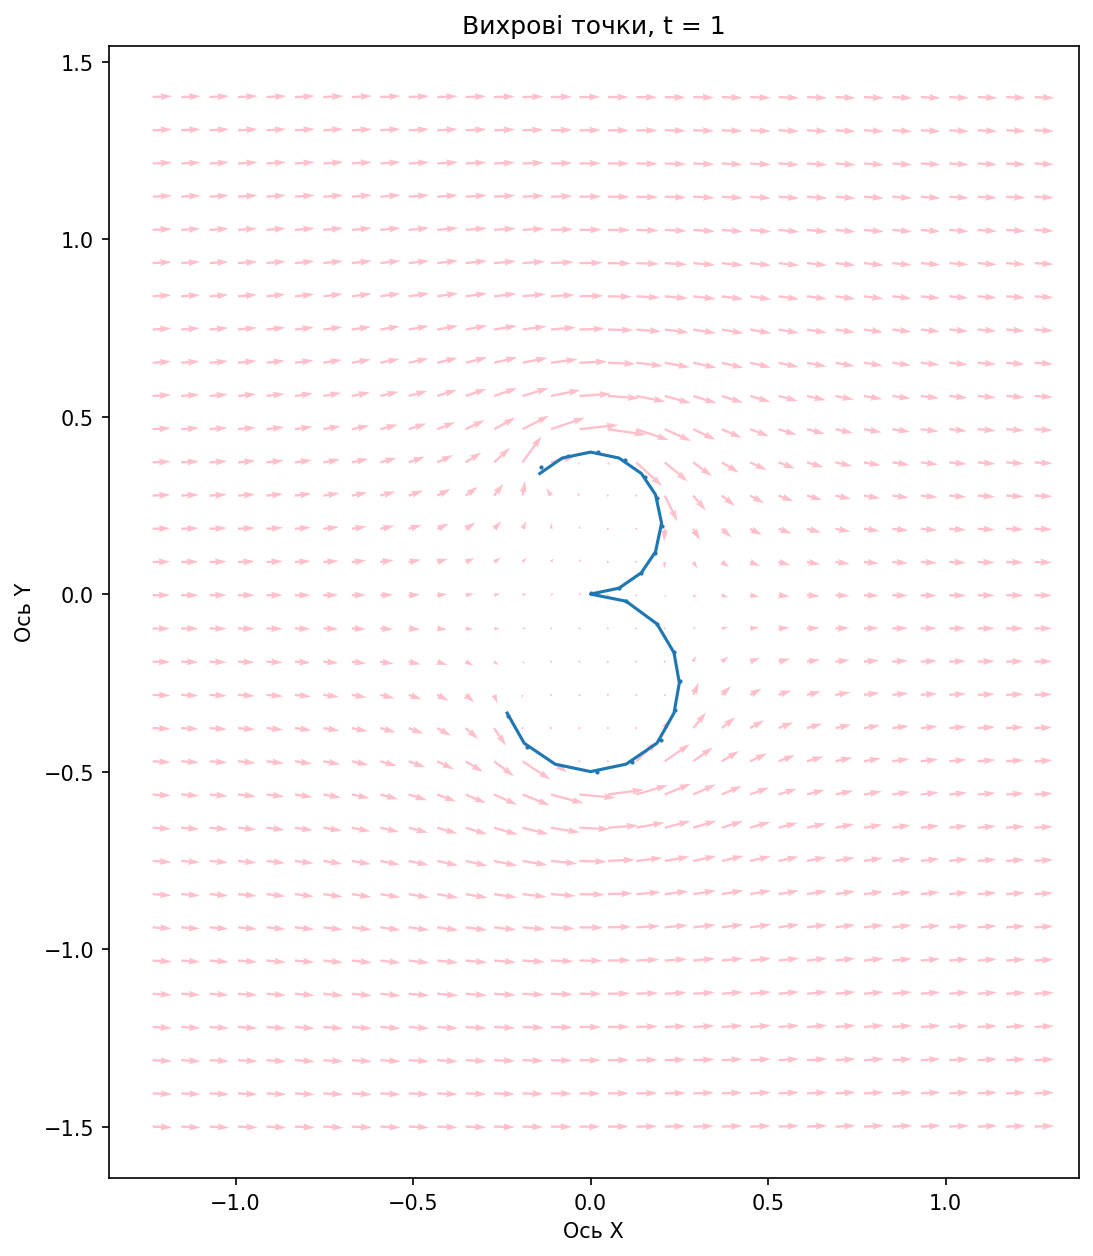

Пройшло  0.8070876598358154 сек. з початку роботи програми


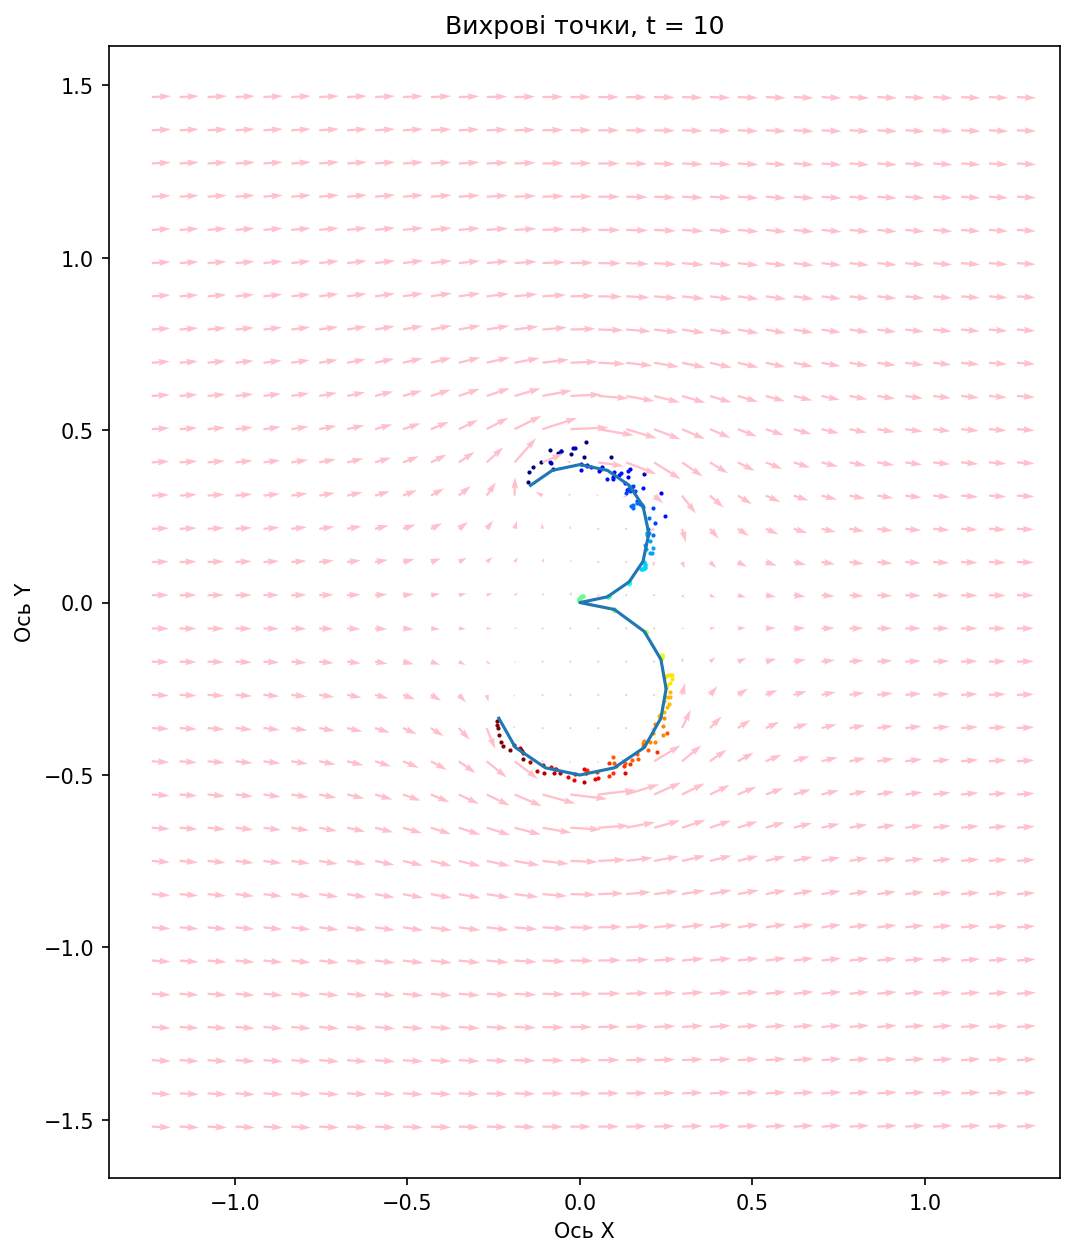

Пройшло  2.5201122760772705 сек. з початку роботи програми


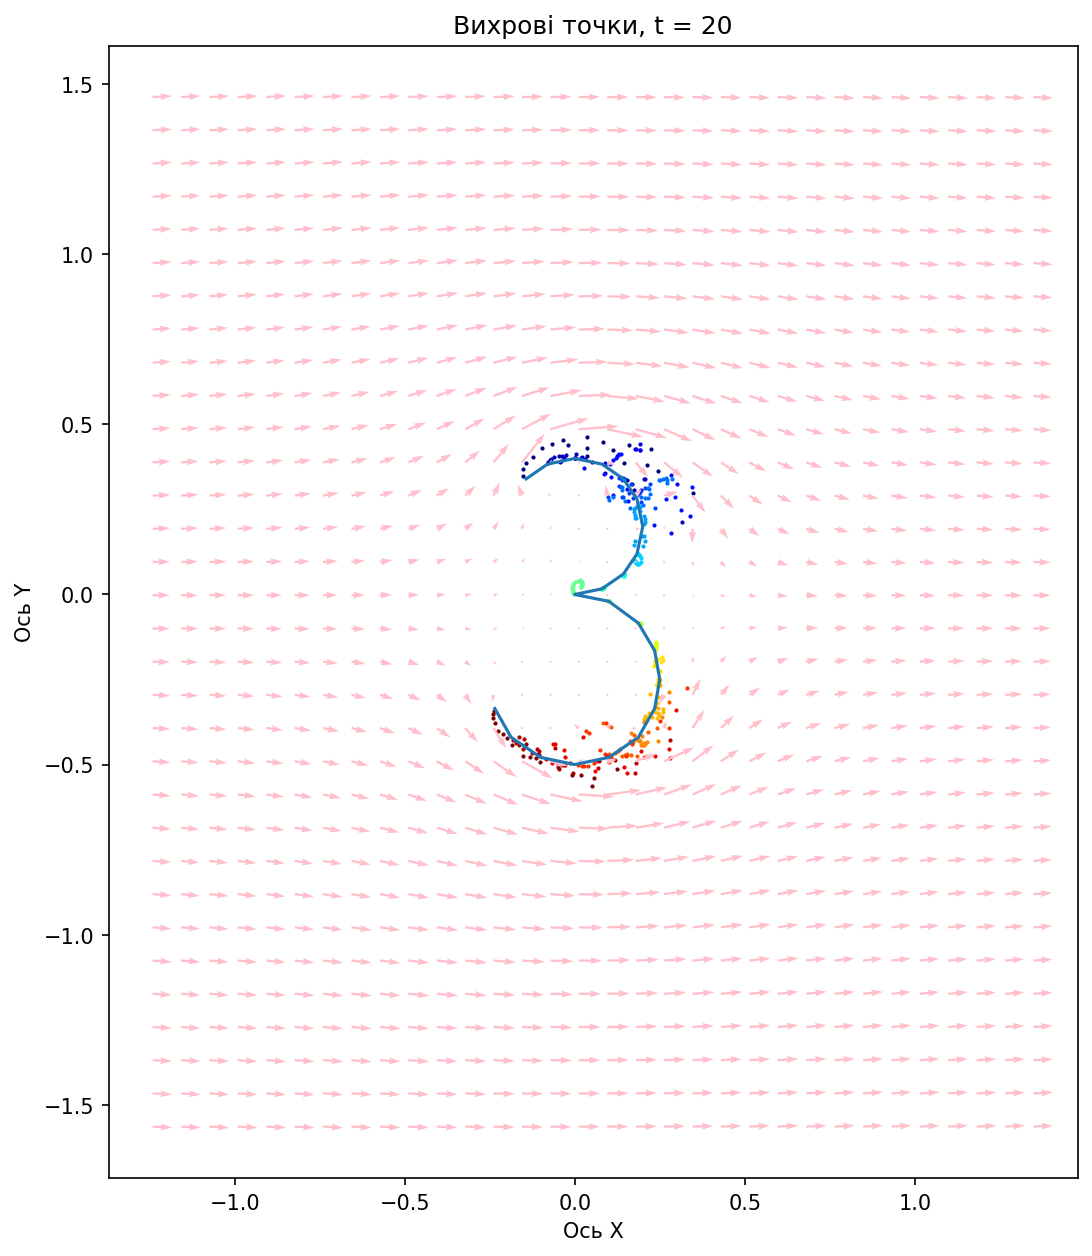

Пройшло  6.838803768157959 сек. з початку роботи програми


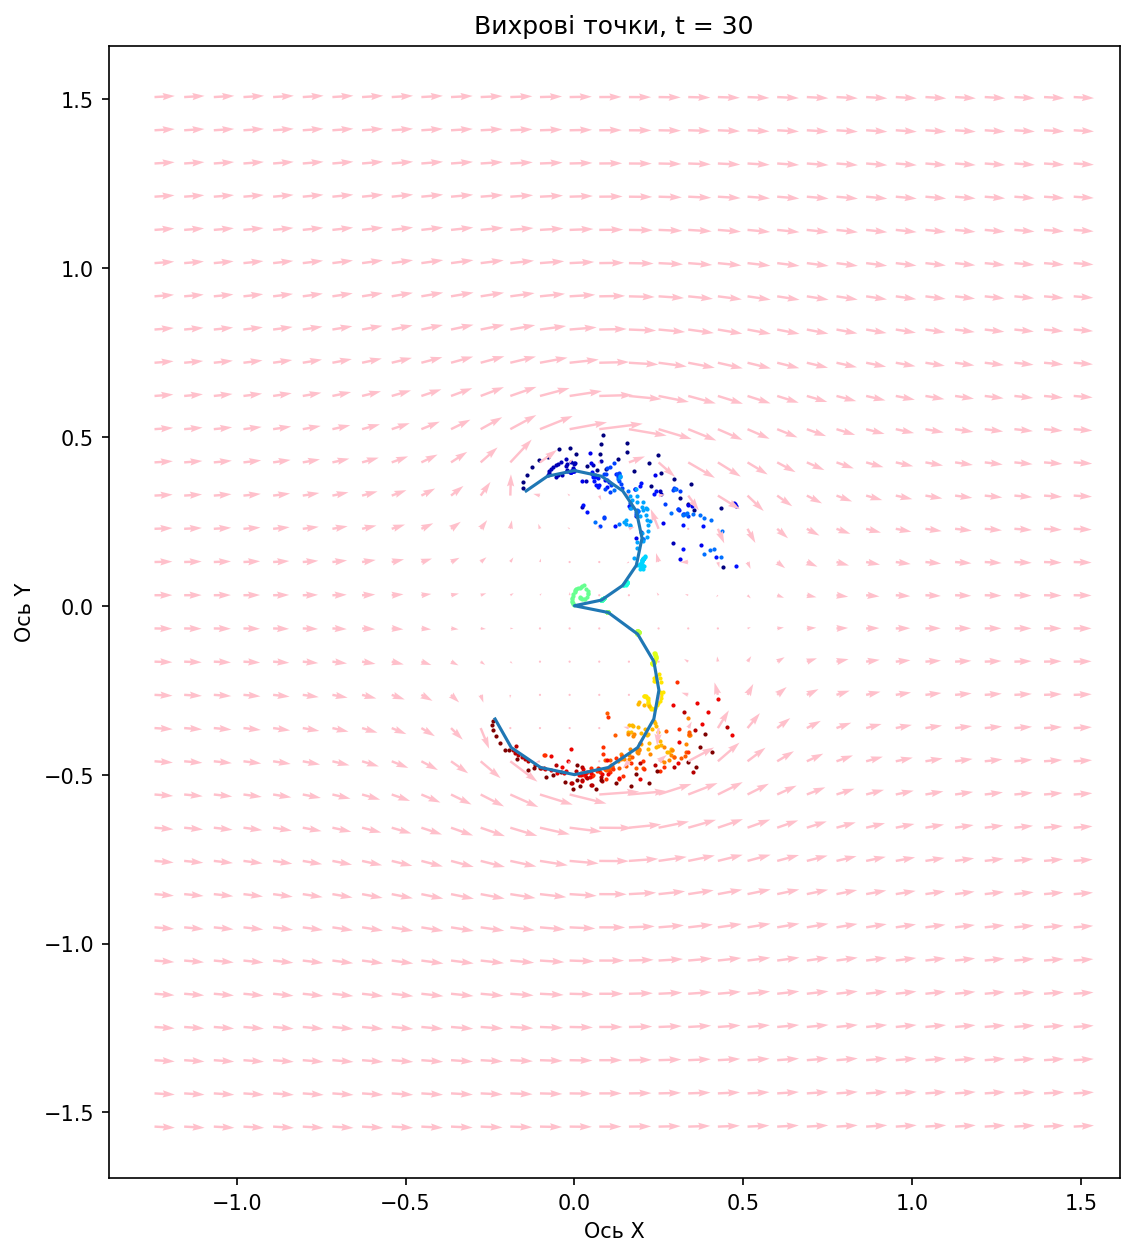

Пройшло  15.120285034179688 сек. з початку роботи програми


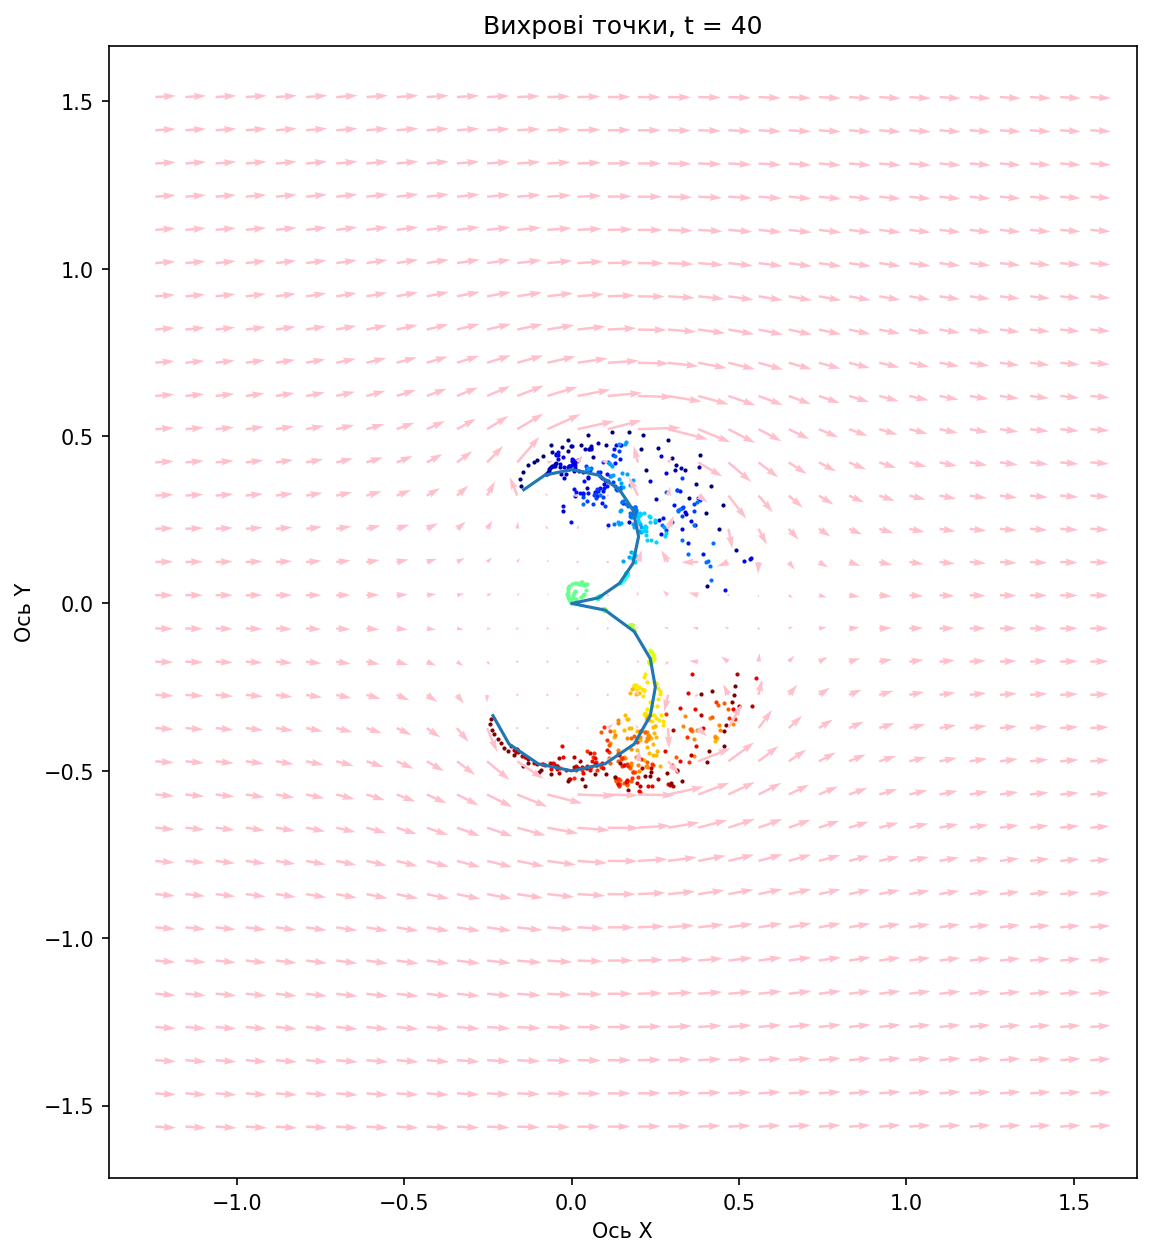

Пройшло  28.993382930755615 сек. з початку роботи програми


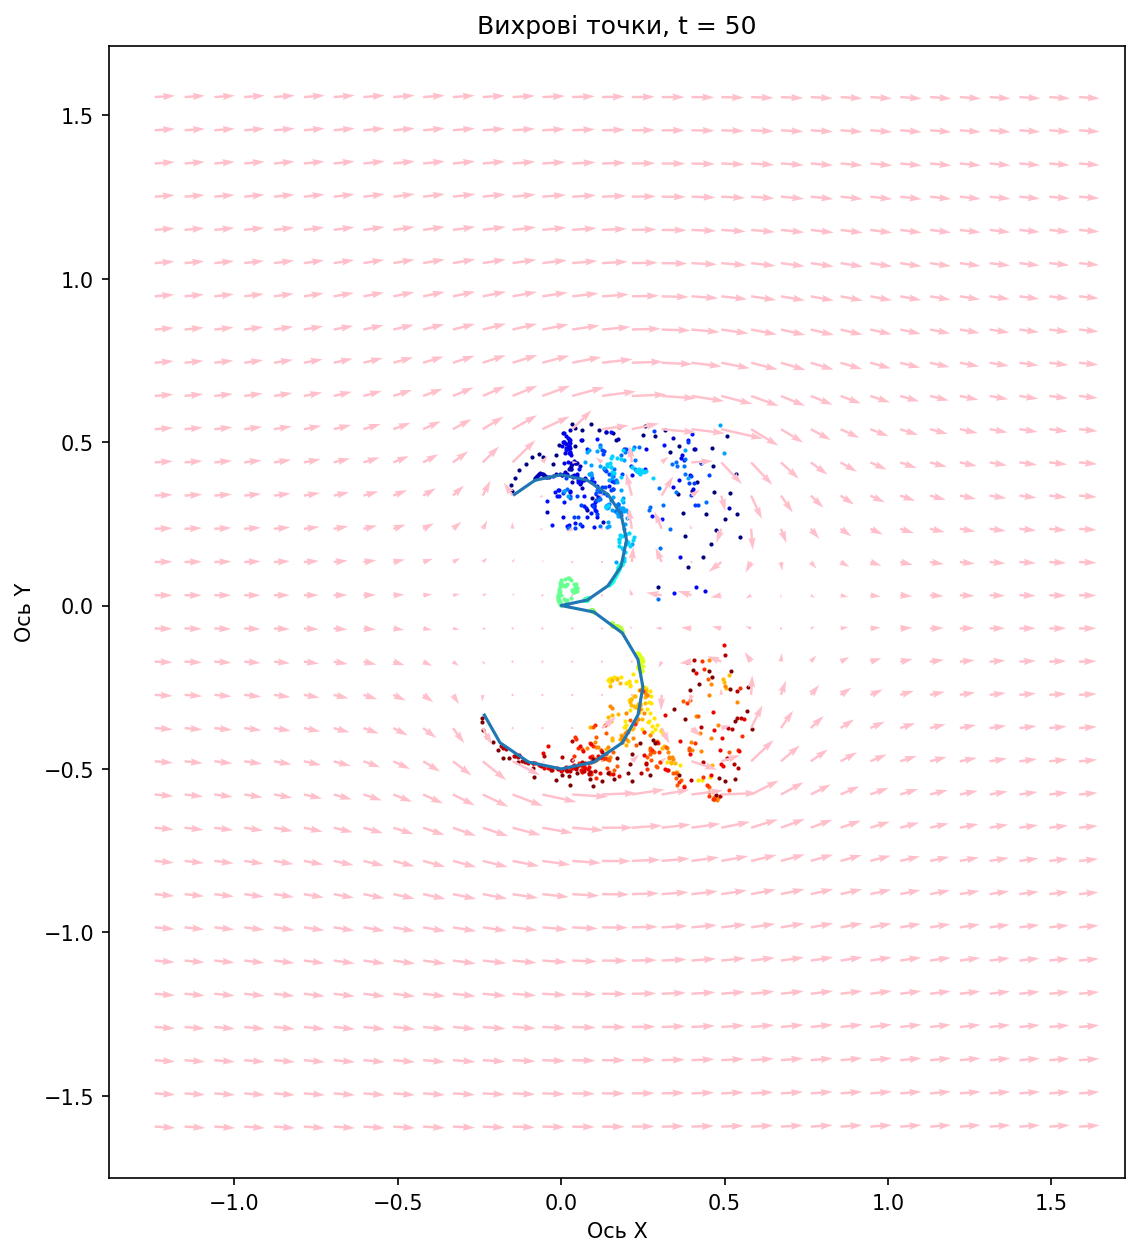

Пройшло  50.775317430496216 сек. з початку роботи програми


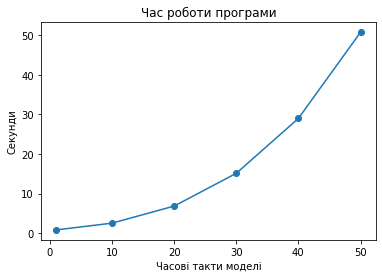

In [5]:
angle = 0 # Кут руху течії
flow = FlowModeling(angle, obstaclePoints, obstacle)  # Ініціалізуємо модель течії

# timePoints = [10, 20, 50, 100, 150, 200, 250, 300]  # Часові точки
timePoints = [1, 10, 20, 30, 40, 50]  # Часові точки
flow.plotVortexPoints(timePoints, vortexColors)

# timePoints = [10, 20, 50, 100, 200, 300, 400, 500, 600]  # Часові точки
# flow.plotKarmanStreet(timePoints, vortexColors)

### Робота програми при куті течії рівному π/4 радіан

In [6]:
# angle = math.pi/4. # Кут руху течії
# flow = FlowModeling(angle, obstaclePoints, obstacle)  # Ініціалізуємо модель течії

# timePoints = [10, 20, 50, 100, 150, 200, 250, 300]  # Часові точки
# flow.plotVortexPoints(timePoints, vortexColors)

# timePoints = [10, 20, 50, 100, 200, 300, 400, 500, 600]  # Часові точки
# flow.plotKarmanStreet(timePoints, vortexColors)